<a href="https://colab.research.google.com/github/ElenaVillano/sentiment_analysis_tweets/blob/main/notebooks/modelado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import nltk
import re
import timeit
import string


#call the nltk downloader
nltk.download('punkt')

from dateutil import parser

from sklearn.model_selection import train_test_split

# Carga un set de stopwords predefinidas
from nltk.corpus import stopwords

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [105]:
# Nombramiento de columnas
col_names = ['target', # Polaridad del twet 0=negativo, 2=neutral, 4=positivo
             'ids',    # ID tweet
             'date',   # Fecha y hora del tweet
             'flag',   # QUERY
             'user',   # Usuario del tweet
             'text']   # Texto del tweet

# Carga y limpieza de datos

In [3]:
# Requiered to select a file to be imported into colab
# Not useful if running locally
from google.colab import files
uploaded = files.upload()

Saving training.1600000.processed.noemoticon.csv to training.1600000.processed.noemoticon.csv
Saving testdata.manual.2009.06.14.csv to testdata.manual.2009.06.14.csv


In [106]:
training = pd.read_csv('training.1600000.processed.noemoticon.csv',
                 encoding='latin-1', names=col_names)

In [107]:
test = pd.read_csv('testdata.manual.2009.06.14.csv', names=col_names)

In [108]:
print(training.shape)
print(test.shape)

(1600000, 6)
(498, 6)


In [109]:
training.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [110]:
# Revisamos si tenemos valores nulos.
print("Revisamos si hay valores nulos en el set de entrenamiento\n", training.isna().sum())

Revisamos si hay valores nulos en el set de entrenamiento
 target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64


In [111]:
# Revisamos si tenemos valores nulos.
print("Revisamos si hay valores nulos en el set de pruebas\n", test.isna().sum())

Revisamos si hay valores nulos en el set de pruebas
 target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64


## Convertimos a minúsculas

In [112]:
def convierte_a_minusculas(df):
    """
    Convierte a minúsculas todas las celdas de tipo str en un dataframe
    ==========
    * Args:
         - df: dataframe
    * Return:
         - df: dataframe en minúsculas
    ==========
    Ejemplo:
        >> dataframe = convierte_a_minusculas(dataframe)
    """

    df = df.applymap(lambda s: s.lower() if type(s) == str else s)

    return df

In [113]:
training = convierte_a_minusculas(training)
test = convierte_a_minusculas(test)

## Reemplazamos las URLs con el texto "URL"

In [114]:
#The regular expression used to match URLs is ((www\.[\S]+)|(https?://[\S]+)).

def reemplazar_URLs(phrase):
  return re.sub("((www\.[\S]+)|(https?://[\S]+))", "url", phrase)

In [115]:
training['text'] = training['text'].map(lambda s: reemplazar_URLs(s))
test['text'] = test['text'].map(lambda s: reemplazar_URLs(s))

## Reemplazamos las menciones @ con la palabra "USER_MENTION"



In [116]:
# The regular expression (regex) used to match user mention is @[\S]+. 2.

In [117]:
def reemplazar_usuarios(phrase):
  return re.sub("@[\S]+", "user_mention", phrase)

In [118]:
training['text'] = training['text'].map(lambda s: reemplazar_usuarios(s))
test['text'] = test['text'].map(lambda s: reemplazar_usuarios(s))

## Quitamos el Hashtag , pero dejamos la palabra

In [119]:
# The regular expression used to match hashtags is #(\S+).

In [120]:
def quitar_hashtag(phrase):
  return re.sub("#(\S+)", "", phrase)

In [121]:
training['text'] = training['text'].map(lambda s: quitar_hashtag(s))
test['text'] = test['text'].map(lambda s: quitar_hashtag(s))

## Quitamos los Retweets, sólo la palabra RT , dejamos el comentario

In [122]:
#  The regular expression used to match retweets is \brt\b.

In [123]:
def quitar_RT(phrase):
  return re.sub("\brt\b", "", phrase)

In [124]:
training['text'] = training['text'].map(lambda s: quitar_RT(s))
test['text'] = test['text'].map(lambda s: quitar_RT(s))

## Quitamos espacios o puntos extras

In [125]:
## Reemplazamos los dobles puntos (o más) con un espacio , dos o más espacios con 1 espacio y hacemos strip de espacios y comillas
# Strip any punctuation [’"?!,.():;-'] from the word ??

In [126]:
def quitar_caracteres_especiales(phrase):
  caracteres_especiales = '’"?!,.():;-'
  # quita dobles espacios y lo hace 1
  phrase = re.sub(' +', ' ', phrase)
  # quita los caracteres especiales
  regex = re.compile('[%s]' % re.escape(caracteres_especiales))

  return regex.sub('', phrase)

In [127]:
training['text'] = training['text'].map(lambda s: quitar_caracteres_especiales(s))
test['text'] = test['text'].map(lambda s: quitar_caracteres_especiales(s))

## Quitamos expresiones con letras repetidas

In [128]:
#Convert 2 or more letter repetitions to 2 letters.
#Some people send tweets like I am sooooo
#happpppy adding multiple characters to emphasize
#on certain words. This is done to handle such tweets
#by converting them to I am soo happy

In [129]:
def quitar_letras_repetidas(phrase):
  return re.sub(r'(.)\1+', r'\1\1', phrase)

In [130]:
training['text'] = training['text'].map(lambda s: quitar_letras_repetidas(s))
test['text'] = test['text'].map(lambda s: quitar_letras_repetidas(s))

## Quitar caracteres nonascii

In [131]:
def quitar_nonascii(phrase):
  return phrase.encode('ascii', errors='ignore').decode('utf-8')

In [132]:
training['text'] = training['text'].map(lambda s: quitar_nonascii(s))
test['text'] = test['text'].map(lambda s: quitar_nonascii(s))

## Removemos stopwords

In [133]:
nltk.download('stopwords') # Use predefined list of stopwords from nltk

STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [134]:
# Aux funcción para substituir abreviaciones
def decontracted(phrase):
  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase

In [135]:
training['text'] = training['text'].map(lambda s: decontracted(s))
test['text'] = test['text'].map(lambda s: decontracted(s))

In [136]:
# Set adicional de stopwords, removeremos palabras tanto de este set como del que
# viene definido en el nltk
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [137]:
# Función auxiliar para remover stopwords y otras estandarizaciones de texto
# (Aqui puedes incluir el lematizador o stemming si gustas explorarlos)
def remove_stopwords(phrase):
    phrase = ' '.join(e.lower() for e in phrase.split() if e.lower() not in stopwords)
    phrase = ' '.join(e.lower() for e in phrase.split() if e.lower() not in STOPWORDS)
    return phrase

In [138]:
training['text'] = training['text'].map(lambda s: remove_stopwords(s))
test['atext'] = test['text'].map(lambda s: remove_stopwords(s))

In [139]:
training

,target,ids,date,flag,user,text
0,0,1467810369,mon apr 06 22:19:45 pdt 2009,no_query,_thespecialone_,user_mention url aww bummer shoulda got david ...
1,0,1467810672,mon apr 06 22:19:49 pdt 2009,no_query,scotthamilton,upset update facebook texting might cry result...
2,0,1467810917,mon apr 06 22:19:53 pdt 2009,no_query,mattycus,user_mention dived many times ball managed sav...
3,0,1467811184,mon apr 06 22:19:57 pdt 2009,no_query,ellectf,whole body feels itchy like fire
4,0,1467811193,mon apr 06 22:19:57 pdt 2009,no_query,karoli,user_mention behaving mad see
...,...,...,...,...,...,...
1599995,4,2193601966,tue jun 16 08:40:49 pdt 2009,no_query,amandamarie1028,woke school best feeling ever
1599996,4,2193601969,tue jun 16 08:40:49 pdt 2009,no_query,thewdboards,thewdbcom cool hear old walt interviews url
1599997,4,2193601991,tue jun 16 08:40:49 pdt 2009,no_query,bpbabe,ready mojo makeover ask details
1599998,4,2193602064,tue jun 16 08:40:49 pdt 2009,no_query,tinydiamondz,happy 38th birthday boo time tupac amaru shakur


## Stemming con NLTK

In [140]:

#create an object of class PorterStemmer
porter = PorterStemmer()
lancaster=LancasterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [141]:
training['text'] = training['text'].map(lambda s: stemSentence(s))
test['atext'] = test['text'].map(lambda s: stemSentence(s))

In [142]:
training

,target,ids,date,flag,user,text
0,0,1467810369,mon apr 06 22:19:45 pdt 2009,no_query,_thespecialone_,user_ment url aww bummer shoulda got david car...
1,0,1467810672,mon apr 06 22:19:49 pdt 2009,no_query,scotthamilton,upset updat facebook text might cri result sch...
2,0,1467810917,mon apr 06 22:19:53 pdt 2009,no_query,mattycus,user_ment dive mani time ball manag save 50 % ...
3,0,1467811184,mon apr 06 22:19:57 pdt 2009,no_query,ellectf,whole bodi feel itchi like fire
4,0,1467811193,mon apr 06 22:19:57 pdt 2009,no_query,karoli,user_ment behav mad see
...,...,...,...,...,...,...
1599995,4,2193601966,tue jun 16 08:40:49 pdt 2009,no_query,amandamarie1028,woke school best feel ever
1599996,4,2193601969,tue jun 16 08:40:49 pdt 2009,no_query,thewdboards,thewdbcom cool hear old walt interview url
1599997,4,2193601991,tue jun 16 08:40:49 pdt 2009,no_query,bpbabe,readi mojo makeov ask detail
1599998,4,2193602064,tue jun 16 08:40:49 pdt 2009,no_query,tinydiamondz,happi 38th birthday boo time tupac amaru shakur


In [143]:
training.target.unique()

array([0, 4])

Quitamos datos al entrenamiento, empecemos con 100,000 

In [144]:
data_set_1 = training.head(50000)
data_set_1 = pd.concat([data_set_1, training.tail(50000)])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


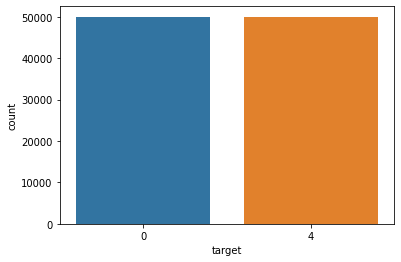

In [149]:
# Revisamos si estan balanceadas las etiquetas
import seaborn as sns
sns.countplot(data_set_1['target'])

# Entrenamos un Tokenizer

In [150]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

# Entrena un Tokenizer. Consiste en:
# Crea un diccionario numerado de las palabras existentes en el corpus, y devuelve
# por cada palabra, el número entero de su índice en el diccionario.
# En este caso, considera las N palabras más frecuentes.
# oov_token = constante asiganda para palabras fuera del vocabulario (NOT USED HERE)


max_words = 1000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_set_1.text)
sequences = tokenizer.texts_to_sequences(data_set_1.text)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[  0   0   0 ...  11 967   5]
 [  0   0   0 ...  53  12 187]
 [  0   0   0 ... 521 335   3]
 ...
 [  0   0   0 ...   0 137 308]
 [  0   0   0 ... 203 306  13]
 [  0   0   0 ...   1   2   1]]


In [151]:
# REVISA distribución: calcula 
y_hist, x_hist = np.histogram(sorted(tokenizer.word_counts.values()), 100)
print(x_hist)
print(y_hist)

[1.000000e+00 4.745800e+02 9.481600e+02 1.421740e+03 1.895320e+03
 2.368900e+03 2.842480e+03 3.316060e+03 3.789640e+03 4.263220e+03
 4.736800e+03 5.210380e+03 5.683960e+03 6.157540e+03 6.631120e+03
 7.104700e+03 7.578280e+03 8.051860e+03 8.525440e+03 8.999020e+03
 9.472600e+03 9.946180e+03 1.041976e+04 1.089334e+04 1.136692e+04
 1.184050e+04 1.231408e+04 1.278766e+04 1.326124e+04 1.373482e+04
 1.420840e+04 1.468198e+04 1.515556e+04 1.562914e+04 1.610272e+04
 1.657630e+04 1.704988e+04 1.752346e+04 1.799704e+04 1.847062e+04
 1.894420e+04 1.941778e+04 1.989136e+04 2.036494e+04 2.083852e+04
 2.131210e+04 2.178568e+04 2.225926e+04 2.273284e+04 2.320642e+04
 2.368000e+04 2.415358e+04 2.462716e+04 2.510074e+04 2.557432e+04
 2.604790e+04 2.652148e+04 2.699506e+04 2.746864e+04 2.794222e+04
 2.841580e+04 2.888938e+04 2.936296e+04 2.983654e+04 3.031012e+04
 3.078370e+04 3.125728e+04 3.173086e+04 3.220444e+04 3.267802e+04
 3.315160e+04 3.362518e+04 3.409876e+04 3.457234e+04 3.504592e+04
 3.551950e

## Separamos en train, test

In [152]:
X_train, X_test, y_train, y_test = train_test_split(tweets, data_set_1.target.values, test_size=0.3, random_state=23042021)

In [153]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (70000, 200)
y_train (70000,)
X_test (30000, 200)
y_test (30000,)


# Creamos el modelo

In [154]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1

## De la clase

In [155]:
# Crea una red con layers Embedding, LSTM, Dense
model = Sequential()
model.add(Embedding(input_length=128, input_dim=max_words, output_dim=64, trainable=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=82, activation='relu'))
model.add(Dense(units=1, activation=None))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 128, 64)           64000     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               33280     
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 82)               

In [71]:
# Compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=[tf.metrics.BinaryAccuracy(), 'accuracy'])

In [72]:
# Train it
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2)# validation_data=(x_val, y_val))

Epoch 1/10
3429/3500 [============================>.] - ETA: 6s - loss: 1.0819e-30 - binary_accuracy: 1.0000 - accuracy: 1.0000

KeyboardInterrupt: ignored

In [ ]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

### RNN, tomado de: https://www.kaggle.com/smitshah00/sentiment-analysis-ml-rnn

In [156]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint


model2 = Sequential()
model2.add(layers.Embedding(max_words, 128))
model2.add(layers.LSTM(64,dropout=0.5))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(1,activation='sigmoid'))
model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         128000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_17 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 178,593
Trainable params: 178,593
Non-trainable params: 0
_________________________________________________________________


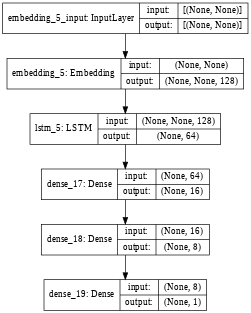

In [157]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(model2, show_shapes=True, show_layer_names=True,
                          rankdir='TB', expand_nested=True, dpi=48)

In [ ]:
# Train
history = model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
786/875 [=========================>....] - ETA: 16s - loss: -362.1311 - accuracy: 0.0038

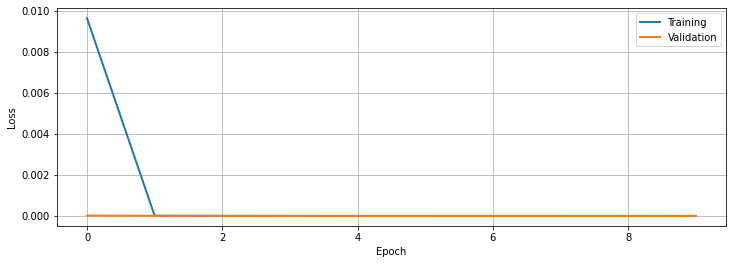

In [54]:
# Plot loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [49]:
#checkpoint2 = ModelCheckpoint("rnn_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
#history = model2.fit(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[checkpoint2])

Epoch 1/10
1750/1750 [==============================] - 256s 145ms/step - loss: 0.0235 - accuracy: 0.9997 - val_loss: 2.5222e-07 - val_accuracy: 1.0000

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to rnn_model.hdf5
Epoch 2/10
1348/1750 [======================>.......] - ETA: 55s - loss: 1.7618e-07 - accuracy: 1.0000

KeyboardInterrupt: ignored

# Probamos

In [ ]:
model = keras.models.load_model('rnn_model.hdf5')
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
pred = model.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')

## De la clase

In [ ]:
# Predict on test set
y_test_hat = tf.round(tf.sigmoid(model.predict(x_test)))

# Print a few examples of indices where label equals True
for ind in range(10):
  print("True:", np.where(y_test[ind] == 1.))
  print("Pred:", np.where(y_test_hat[ind] == 1.), "\n")

# Print a few examples of whole vectors
print("Test ground-truth:")
print(y_test[:5])
print("\n Test prediction:")
print(y_test_hat[:5])

In [ ]:
# Get embeddings
embeddings = np.copy(model.layers[0].get_weights()[0])

print(embeddings.shape)
print(embeddings.min())
print(embeddings.max())

In [ ]:
#
embeddings -= embeddings.min()
embeddings /= embeddings.max()

# Plot embeddings
plt.figure(figsize=(12, 4))
plt.imshow(embeddings[:80], cmap='jet')
plt.title('Primeros 80 embeddings (1000 -> 64)')
plt.colorbar()
plt.tight_layout()
plt.show()